# Using SAGE-based FDR calculation

This notebook shows how to use the **original SAGE functions** to translate **raw-scores** to **q-values**. You will:
* Read in a dataset
* Score the extracted pairs of precursor information and fragment spectra
* **Calculate spectrum-q, peptide-q, and protein-q** using the original SAGE functions
* Visualize the results

This notebook makes use of [`imspy`](https://pypi.org/project/imspy/) to load a [timsTOF HeLa dataset](https://proteomecentral.proteomexchange.org/cgi/GetDataset?ID=PXD043026), but feel free to use any other data source.

In [31]:
from imspy.timstof import extract_timstof_dda_data

# This function will extract raw timsTOF dda data and generate a ready-to-score dataset from it, data read in can take a minute or two
raw_data = extract_timstof_dda_data(
    path="/media/hd01/CCSPred/HELA-GRAD110/M210115_001_Slot1-1_1_850.d/",
    in_memory=False,
    use_bruker_sdk=True,
)

/home/administrator/Documents/promotion/ENV-11/lib/python3.11/site-packages/imspy/timstof/dda.py:71: UserWarning: Using multiple threads is currently not supported when using Bruker SDK, setting num_threads to 1.
  warnings.warn("Using multiple threads is currently not supported when using Bruker SDK, "


In [2]:
import pandas as pd

from sagepy.utility import create_sage_database

# give the path to the HeLa fasta (human)
fasta_path = "/media/hd02/data/fasta/hela/plain/uniprotkb_proteome_UP000005640_AND_revi_2024_05_21.fasta"

# define the modifications you want to include into the search space
# static mods need to be given as key value pairs of the amino acid and the modification that should be applied
static_mods = {
    # Carbamidomethylation C
    "C": "[UNIMOD:4]"
}

# variable mods should be given as key value pairs of the amino acids and a list of all modifications that should be applied to them
# [X, ]X mean PROTEIN N and C terminal modification applied to amino acid X;
# ^X, $X mean PEPTIDE  N and C terminal modification applied to amino acid X;
variable_mods = {
    # any M should also be generated with UNIMOD:35 (Oxidation)
    "M": ["[UNIMOD:1]", "[UNIMOD:35]"], 
    # Protein N-terminal should als be generated with UNIMOD:1 (Acetylation) 
    "[": ["[UNIMOD:1]"]
}

# for simplicity, we can use the create_sage_database function, that creates a sage indexed database with tryptic settings
indexed_database = create_sage_database(
    fasta_path = fasta_path,
    static_mods = static_mods,
    variable_mods = variable_mods
)

In [7]:
# Score the spectra and create a collection of PSMs (list)
from sagepy.core import Scorer

scorer = Scorer(report_psms=5, min_matched_peaks=5, static_mods=static_mods, variable_mods=variable_mods)

# the scorer returns a dict of type PeptideSpectrumMatch, an object that holds information about the PSM
# where the types are Dict[spec_id -> List[PSM]]
psms = scorer.score_collection_psm(
    db=indexed_database, 
    spectrum_collection=raw_data.processed_spec.values,
    num_threads=16,
)

psm_list = []

for k, v in psms.items():
    if len(v) > 0:
        psm_list.extend(v)

## Use SAGE Internal FDR Methods

For simplicity, the `sage_fdr_psm` function calculates spectrum-q, peptide-q, and protein-q in a single function call. It is also possible to run these calculations individually. 

Since SAGE uses a picked peptide/protein approach, PSMs are assigned the lowest peptide or protein q-value even if their spectrum q-value is higher. Consequently, q-values might be low even for low hyperscore values on PSM level. Therefore, it is important to keep in mind at which level information is summarized.

In [28]:
from sagepy.core.fdr import sage_fdr_psm

# This function changes the PSMs in-place, meaning the so-far 1.0 defaults q-values are replaced with the SAGE calculated ones
sage_fdr_psm(psm_list, indexed_database, use_hyper_score=True)

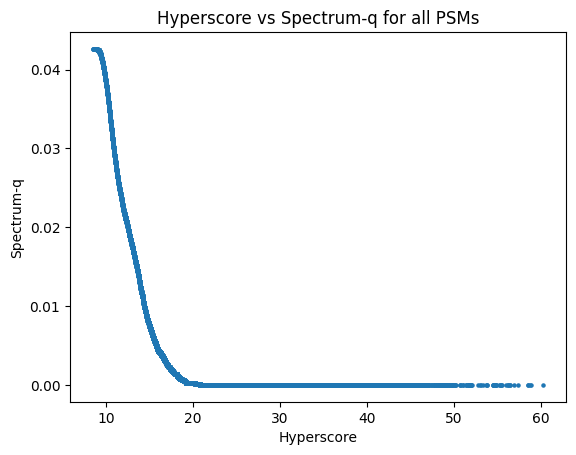

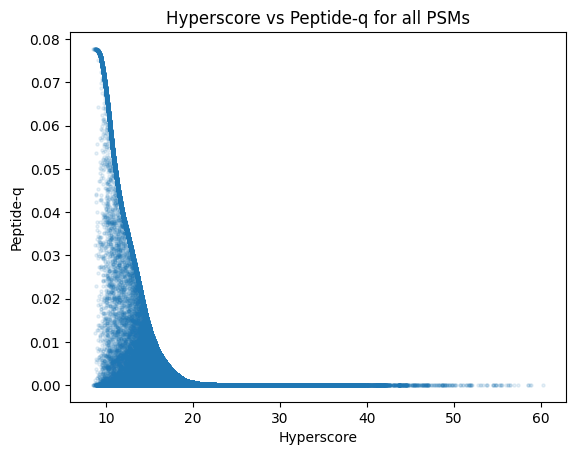

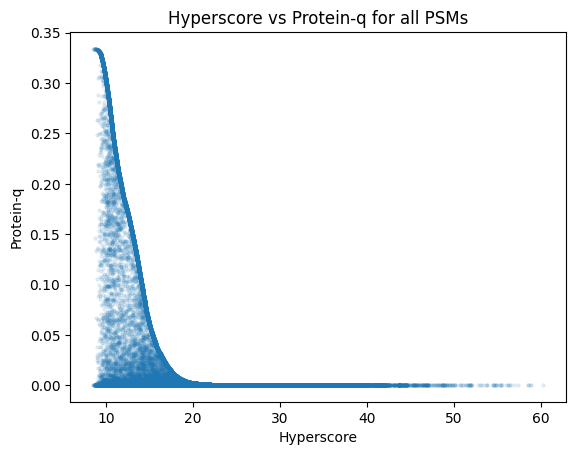

In [30]:
# Plot the results
plt.title("Hyperscore vs Spectrum-q for all PSMs")
plt.scatter([x.sage_feature.hyperscore for x in psm_list], [x.sage_feature.spectrum_q for x in psm_list], s=5)
plt.xlabel("Hyperscore")
plt.ylabel("Spectrum-q")
plt.show()

plt.title("Hyperscore vs Peptide-q for all PSMs")
plt.scatter([x.sage_feature.hyperscore for x in psm_list], [x.sage_feature.peptide_q for x in psm_list], s=5, alpha=.1)
plt.xlabel("Hyperscore")
plt.ylabel("Peptide-q")
plt.show()

plt.title("Hyperscore vs Protein-q for all PSMs")
plt.scatter([x.sage_feature.hyperscore for x in psm_list], [x.sage_feature.protein_q for x in psm_list], s=5, alpha=.1)
plt.xlabel("Hyperscore")
plt.ylabel("Protein-q")
plt.show()